In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

## Set the seed for reproducibility

In [2]:
SEED = 44
np.random.seed(SEED)
random.seed(SEED)

## Load the data

In [3]:
import os

data_path = "data/features/synthbuster/standard"
suffix = "features/extraction_params/train_test/features_RGB.csv"
dalle2 = pd.read_csv(os.path.join(data_path, "dalle2", suffix), index_col=0)
dalle3 = pd.read_csv(os.path.join(data_path, "dalle3", suffix), index_col=0)
firefly = pd.read_csv(os.path.join(data_path, "firefly", suffix), index_col=0)
glide = pd.read_csv(os.path.join(data_path, "glide", suffix), index_col=0)
img = pd.read_csv(os.path.join(data_path, "img", suffix), index_col=0)
midjourney = pd.read_csv(os.path.join(data_path, "midjourney-v5", suffix), index_col=0)
sd_1_3 = pd.read_csv(os.path.join(data_path, "stable-diffusion-1-3", suffix), index_col=0)
sd_1_4 = pd.read_csv(os.path.join(data_path, "stable-diffusion-1-4", suffix), index_col=0)
sd_2 = pd.read_csv(os.path.join(data_path, "stable-diffusion-2", suffix), index_col=0)
sd_xl = pd.read_csv(os.path.join(data_path, "stable-diffusion-xl", suffix), index_col=0)

In [4]:
datasets_train = {
    "dalle2": dalle2,
    "dalle3": dalle3,
    "firefly": firefly,
    "glide": glide,
    "midjourney": midjourney,
    "sd_1_3": sd_1_3,
    "sd_1_4": sd_1_4,
    "sd_2": sd_2,
    "sd_xl": sd_xl,
}

In [5]:
for dataset_name, dataset in datasets_train.items():
    datasets_train[dataset_name] = pd.concat([datasets_train[dataset_name], img])

## Data preparation

In [6]:
def drop_columns(df, drop_only_diagnostic=False):
    to_drop = list()
    for column in df.columns:
        if df[column].min() == df[column].max() and not drop_only_diagnostic:
            to_drop.append(column)
        elif 'diagnostics' in column:
            to_drop.append(column)
        elif 'Mask' in column:
            to_drop.append(column)
    df.drop(to_drop, axis=1, inplace=True)
            
def preprocess_dataset(df, **kwargs):
    # print indexes and image names of rows with NaN values
    nans = df[df.isnull().any(axis=1)]['Image'].apply(lambda x : x.split('/')[-1])
    if not nans.empty:
        print(f"Rows with NaN values:")
        print(nans)
    df.dropna(inplace=True)  
    drop_columns(df, **kwargs)
    
def unify_columns(base_columns, df):
    # drop columns that are not in base_columns
    for column in df.columns:
        if column not in base_columns:
            df.drop(column, axis=1, inplace=True)

### Drop unimportant columns

In [7]:
# We drop only columns from train set
for key, df in datasets_train.items():
    preprocess_dataset(df, drop_only_diagnostic=True)

### Split into train and test set

In [8]:
from sklearn.model_selection import train_test_split

X_train = {}
X_val = {}
X_test = {}

y_train = {}
y_val = {}
y_test = {}

Image_train = {}
Image_val = {}
Image_test = {}

for key, df in datasets_train.items():
    X = df.drop('Category', axis=1)
    y = df['Category']
    
    # get train, val and test sets
    X_train[key], X_test[key], y_train[key], y_test[key] = train_test_split(X, y, test_size=0.2, random_state=SEED)
    X_train[key], X_val[key], y_train[key], y_val[key] = train_test_split(X_train[key], y_train[key], test_size=0.2, random_state=SEED)
    
    Image_train[key] = X_train[key]['Image']
    Image_val[key] = X_val[key]['Image']
    Image_test[key] = X_test[key]['Image']
    
    X_train[key] = X_train[key].drop('Image', axis=1)
    X_val[key] = X_val[key].drop('Image', axis=1)
    X_test[key] = X_test[key].drop('Image', axis=1)
    
# create dataset combining all train sets
X_train_all = pd.concat([X_train[key] for key in datasets_train.keys()])
y_train_all = pd.concat([y_train[key] for key in datasets_train.keys()])

# create dataset combining all val sets
X_val_all = pd.concat([X_val[key] for key in datasets_train.keys()])
y_val_all = pd.concat([y_val[key] for key in datasets_train.keys()])

# create dataset combining all test sets
X_test_all = pd.concat([X_test[key] for key in datasets_train.keys()])
y_test_all = pd.concat([y_test[key] for key in datasets_train.keys()])

X_train['combined'] = X_train_all
y_train['combined'] = y_train_all

X_val['combined'] = X_val_all
y_val['combined'] = y_val_all

X_test['combined'] = X_test_all
y_test['combined'] = y_test_all

### Scale the data

In [9]:
from sklearn.preprocessing import MinMaxScaler

scalers = {}
X_train_scaled = {}
for key in X_train.keys():
    scalers[key] = MinMaxScaler()
    X_train_scaled[key] = scalers[key].fit_transform(X_train[key])
    X_train_scaled[key] = pd.DataFrame(X_train_scaled[key], columns=X_train[key].columns)

## Model training

In [10]:
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC

models = {}
for dataset_name in X_train.keys():
    print(f"\n\nTraining set: {dataset_name}\n")

    models_temp = [
        HistGradientBoostingClassifier(random_state=SEED),
        LinearDiscriminantAnalysis(),
        RandomForestClassifier(random_state=SEED),
        LinearSVC(random_state=SEED),
    ]

    model_temp_dict = { model.__class__.__name__: model for model in models_temp }

    for name, model in model_temp_dict.items():
        model = model.fit(X_train_scaled[dataset_name], y_train[dataset_name].values.ravel())
        print(f"Finished training {name}.")
        print(f"Training accuracy: {model.score(X_train_scaled[dataset_name], y_train[dataset_name].values.ravel())}")
        
    models[dataset_name] = model_temp_dict



Training set: dalle2

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: dalle3

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: firefly

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: glide

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0
Finished training LinearSVC.
Training accuracy: 1.0


Training set: midjourney

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: sd_1_3

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: sd_1_4

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: sd_2

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: sd_xl

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: combined

Finished training HistGradientBoostingClassifier.
Training accuracy: 0.9998263888888889
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9998263888888889
Finished training RandomForestClassifier.
Training accuracy: 1.0
Finished training LinearSVC.
Training accuracy: 0.9995659722222222


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Evaluation

In [11]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
    confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef

def evaluate_model(model, X_test, y_test, print_results=True, name=None):
    if name is not None:
        name = model.__class__.__name__
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    
    if print_results:
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1: {f1:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"MCC: {mcc:.4f}")
    
    return accuracy, f1, precision, recall, mcc

def plot_confusion_matrix(model, X_test, y_test, name=None):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.title(name)
    plt.show()

### Validation data

In [30]:
results = {}
for dataset_name in models.keys():
    print(f"\n\n\n\n *** Evaluating models trained on {dataset_name}. ***")
    for val_dataset_name in X_val.keys():
        print(f"\n\nValidation set: {val_dataset_name}")
        for model_name, model in models[dataset_name].items():
            print()  
            X_val_scaled = scalers[dataset_name].transform(X_val[val_dataset_name][X_train[dataset_name].columns])
            X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train[dataset_name].columns)
            accuracy, f1, precision, recall, mcc = evaluate_model(model, X_val_scaled, y_val[val_dataset_name], name=model_name)
            model_results = {
                "accuracy": accuracy,
                "f1": f1,
                "precision": precision,
                "recall": recall,
                "mcc": mcc
            }
            results[(dataset_name, val_dataset_name, model_name)] = model_results
            
            





 *** Evaluating models trained on dalle2. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9969
F1: 0.9969
Precision: 0.9969
Recall: 0.9969
MCC: 0.9938

Model: LinearDiscriminantAnalysis
Accuracy: 0.9094
F1: 0.9094
Precision: 0.9098
Recall: 0.9094
MCC: 0.8192

Model: RandomForestClassifier
Accuracy: 0.9938
F1: 0.9938
Precision: 0.9938
Recall: 0.9938
MCC: 0.9875

Model: LinearSVC
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.7500
F1: 0.7356
Precision: 0.8291
Recall: 0.7500
MCC: 0.5761

Model: LinearDiscriminantAnalysis
Accuracy: 0.6219
F1: 0.5864
Precision: 0.6968
Recall: 0.6219
MCC: 0.3149

Model: RandomForestClassifier
Accuracy: 0.7937
F1: 0.7860
Precision: 0.8506
Recall: 0.7937
MCC: 0.6433

Model: LinearSVC
Accuracy: 0.8219
F1: 0.8167
Precision: 0.8693
Recall: 0.8219
MCC: 0.6907


Validation set: firefly

Model: HistGradientBoostingClassifier
Accur

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5188
F1: 0.3870
Precision: 0.7108
Recall: 0.5188
MCC: 0.1509

Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.4875
F1: 0.3216
Precision: 0.2399
Recall: 0.4875
MCC: -0.0570



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9969
F1: 0.9969
Precision: 0.9969
Recall: 0.9969
MCC: 0.9938

Model: LinearDiscriminantAnalysis
Accuracy: 0.9969
F1: 0.9969
Precision: 0.9969
Recall: 0.9969
MCC: 0.9938

Model: RandomForestClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearSVC
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.5219
F1: 0.3932
Precision: 0.7154
Recall: 0.5219
MCC: 0.1608

Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.4875
F1: 0.3216
Precision: 0.2399
Recall: 0.4875
MCC: -0.0570



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3284
Precision: 0.4954
Recall: 0.4906
MCC: -0.0015

Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.4906
F1: 0.3284
Precision: 0.4954
Recall: 0.4906
MCC: -0.0015

Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: sd_xl



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3486
Precision: 0.6505
Recall: 0.5000
MCC: 0.0732

Model: LinearDiscriminantAnalysis
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3230
Precision: 0.2407
Recall: 0.4906
MCC: 0.0000


Validation set: combined



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5538
F1: 0.4533
Precision: 0.7435
Recall: 0.5538
MCC: 0.2435

Model: LinearDiscriminantAnalysis
Accuracy: 0.5472
F1: 0.4376
Precision: 0.7645
Recall: 0.5472
MCC: 0.2404

Model: RandomForestClassifier
Accuracy: 0.5472
F1: 0.4376
Precision: 0.7645
Recall: 0.5472
MCC: 0.2404

Model: LinearSVC
Accuracy: 0.5472
F1: 0.4376
Precision: 0.7645
Recall: 0.5472
MCC: 0.2404




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9812
F1: 0.9812
Precision: 0.9819
Recall: 0.9812
MCC: 0.9631

Model: LinearDiscriminantAnalysis
Accuracy: 0.7781
F1: 0.7776
Precision: 0.7826
Recall: 0.7781
MCC: 0.5610

Model: RandomForestClassifier
Accuracy: 0.9469
F1: 0.9469
Precision: 0.9469
Recall: 0.9469
MCC: 0.8937

Model: LinearSVC
Accuracy: 0.9313
F1: 0.9311
Precision: 0.9382
Recall: 0.9313
MCC: 0.8696


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.9500
F1: 0.9500


In [31]:
def present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name="Validation", metric="accuracy"):
    # Get only for the LDA model
    model_df = df[df["model"] == name]
    # Leave only the accuracy, train_dataset, and val_dataset columns
    val_dataset_name = "val_dataset" if evaluation_data_name == "Validation" else "test_dataset"
    model_df = model_df[["train_dataset", val_dataset_name, metric]]
    # Pivot the table
    df_pivot = model_df.pivot(index="train_dataset", columns=val_dataset_name, values=metric)
    # reorganize columns and indexes
    df_pivot = df_pivot.reindex(index=X_train.keys())
    df_pivot = df_pivot.reindex(columns=X_train.keys())

    plt.figure(figsize=(10, 7))
    plt.imshow(df_pivot, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.xticks(np.arange(len(df_pivot.columns)), df_pivot.columns, rotation=45)
    plt.yticks(np.arange(len(df_pivot.index)), df_pivot.index)
    plt.xlabel(f"{evaluation_data_name} dataset")
    plt.ylabel("Train dataset")
    plt.title(f"{name} - {metric}")
    plt.show()
    
    display(df_pivot)
    
    # exclude combined val_dataset
    df_avg = df_pivot.drop("combined", axis=1)
    # calculate average accuracy for each train dataset (don't include combined)
    df_avg["average"] = df_avg.mean(axis=1)
    display(df_avg)

    return df_pivot, df_avg


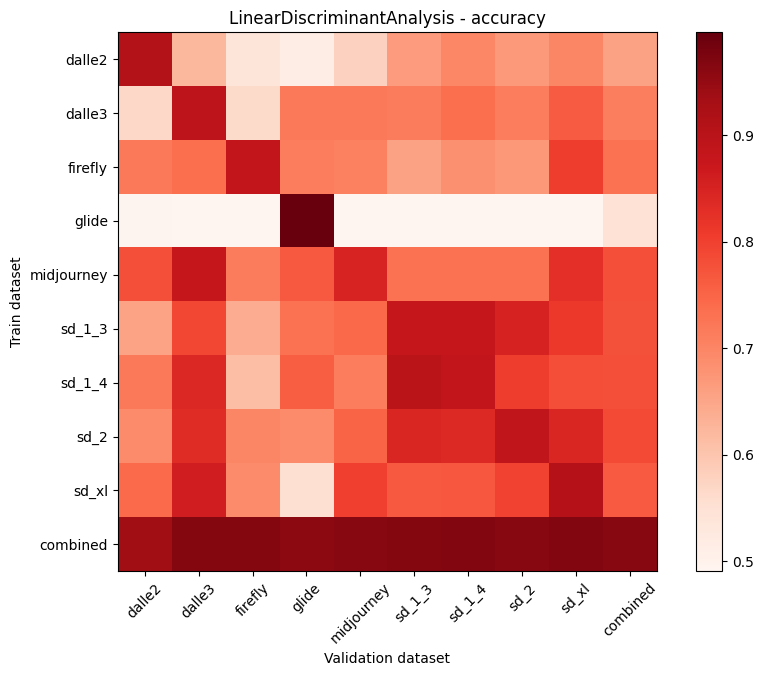

val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.909375,0.621875,0.537500,0.515625,0.578125,0.665625,0.696875,0.668750,0.700000,0.654861
dalle3,0.568750,0.893750,0.562500,0.718750,0.718750,0.715625,0.737500,0.712500,0.762500,0.710069
firefly,0.718750,0.734375,0.884375,0.712500,0.706250,0.656250,0.684375,0.671875,0.803125,0.730208
glide,0.493750,0.490625,0.490625,0.996875,0.490625,0.490625,0.490625,0.490625,0.490625,0.547222
midjourney,0.778125,0.881250,0.715625,0.765625,0.846875,0.731250,0.731250,0.731250,0.828125,0.778819
sd_1_3,0.653125,0.790625,0.640625,0.731250,0.743750,0.881250,0.881250,0.850000,0.812500,0.776042
sd_1_4,0.718750,0.840625,0.609375,0.759375,0.712500,0.896875,0.884375,0.803125,0.781250,0.778472
sd_2,0.690625,0.834375,0.700000,0.690625,0.750000,0.843750,0.837500,0.887500,0.843750,0.786458
sd_xl,0.740625,0.859375,0.690625,0.553125,0.800000,0.765625,0.768750,0.796875,0.906250,0.764583


val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.909375,0.621875,0.537500,0.515625,0.578125,0.665625,0.696875,0.668750,0.700000,0.654861
dalle3,0.568750,0.893750,0.562500,0.718750,0.718750,0.715625,0.737500,0.712500,0.762500,0.710069
firefly,0.718750,0.734375,0.884375,0.712500,0.706250,0.656250,0.684375,0.671875,0.803125,0.730208
glide,0.493750,0.490625,0.490625,0.996875,0.490625,0.490625,0.490625,0.490625,0.490625,0.547222
midjourney,0.778125,0.881250,0.715625,0.765625,0.846875,0.731250,0.731250,0.731250,0.828125,0.778819
sd_1_3,0.653125,0.790625,0.640625,0.731250,0.743750,0.881250,0.881250,0.850000,0.812500,0.776042
sd_1_4,0.718750,0.840625,0.609375,0.759375,0.712500,0.896875,0.884375,0.803125,0.781250,0.778472
sd_2,0.690625,0.834375,0.700000,0.690625,0.750000,0.843750,0.837500,0.887500,0.843750,0.786458
sd_xl,0.740625,0.859375,0.690625,0.553125,0.800000,0.765625,0.768750,0.796875,0.906250,0.764583


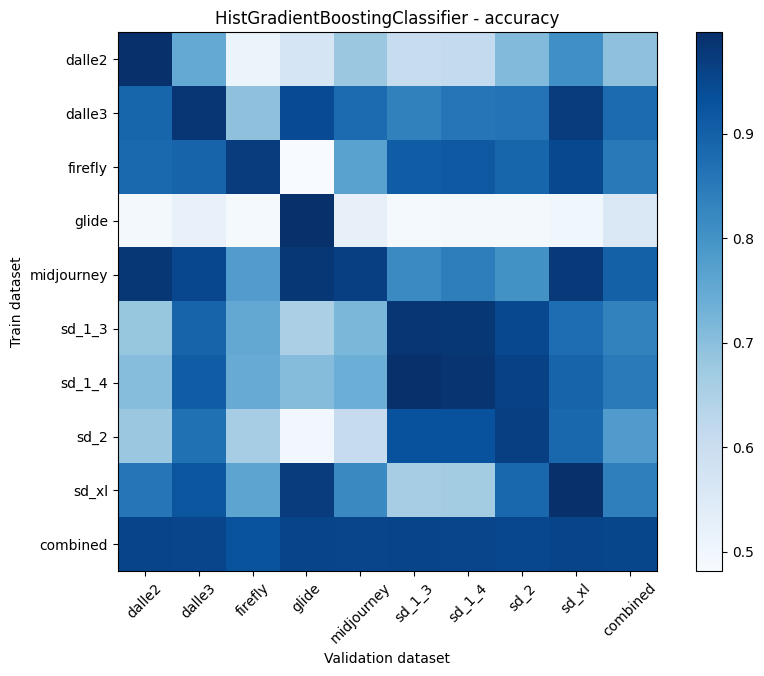

val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.996875,0.750000,0.512500,0.568750,0.678125,0.603125,0.612500,0.709375,0.806250,0.693056
dalle3,0.890625,0.984375,0.693750,0.940625,0.878125,0.834375,0.856250,0.862500,0.971875,0.879167
firefly,0.884375,0.893750,0.971875,0.481250,0.765625,0.906250,0.915625,0.890625,0.946875,0.850694
glide,0.490625,0.518750,0.487500,0.996875,0.521875,0.487500,0.490625,0.490625,0.500000,0.553819
midjourney,0.981250,0.950000,0.778125,0.981250,0.965625,0.815625,0.840625,0.803125,0.975000,0.898958
sd_1_3,0.684375,0.893750,0.753125,0.653125,0.718750,0.984375,0.981250,0.946875,0.875000,0.832292
sd_1_4,0.703125,0.906250,0.743750,0.706250,0.737500,0.996875,0.987500,0.962500,0.893750,0.848611
sd_2,0.678125,0.868750,0.662500,0.493750,0.606250,0.931250,0.931250,0.965625,0.887500,0.780556
sd_xl,0.859375,0.921875,0.759375,0.971875,0.818750,0.662500,0.665625,0.887500,0.993750,0.837847


val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.996875,0.750000,0.512500,0.568750,0.678125,0.603125,0.612500,0.709375,0.806250,0.693056
dalle3,0.890625,0.984375,0.693750,0.940625,0.878125,0.834375,0.856250,0.862500,0.971875,0.879167
firefly,0.884375,0.893750,0.971875,0.481250,0.765625,0.906250,0.915625,0.890625,0.946875,0.850694
glide,0.490625,0.518750,0.487500,0.996875,0.521875,0.487500,0.490625,0.490625,0.500000,0.553819
midjourney,0.981250,0.950000,0.778125,0.981250,0.965625,0.815625,0.840625,0.803125,0.975000,0.898958
sd_1_3,0.684375,0.893750,0.753125,0.653125,0.718750,0.984375,0.981250,0.946875,0.875000,0.832292
sd_1_4,0.703125,0.906250,0.743750,0.706250,0.737500,0.996875,0.987500,0.962500,0.893750,0.848611
sd_2,0.678125,0.868750,0.662500,0.493750,0.606250,0.931250,0.931250,0.965625,0.887500,0.780556
sd_xl,0.859375,0.921875,0.759375,0.971875,0.818750,0.662500,0.665625,0.887500,0.993750,0.837847


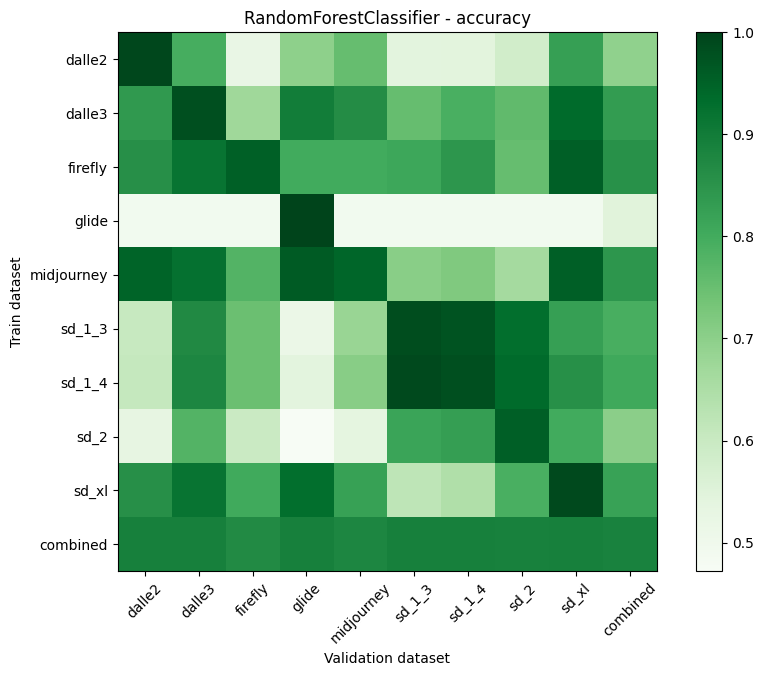

val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.993750,0.793750,0.521875,0.696875,0.753125,0.540625,0.543750,0.581250,0.825000,0.694444
dalle3,0.837500,0.981250,0.671875,0.896875,0.865625,0.753125,0.790625,0.759375,0.934375,0.832292
firefly,0.859375,0.915625,0.953125,0.800000,0.800000,0.809375,0.843750,0.753125,0.956250,0.854514
glide,0.490625,0.490625,0.490625,1.000000,0.490625,0.490625,0.490625,0.490625,0.490625,0.547222
midjourney,0.946875,0.921875,0.778125,0.962500,0.943750,0.703125,0.718750,0.662500,0.956250,0.843750
sd_1_3,0.603125,0.871875,0.746875,0.515625,0.681250,0.984375,0.975000,0.928125,0.825000,0.792361
sd_1_4,0.606250,0.878125,0.746875,0.540625,0.706250,0.990625,0.981250,0.934375,0.856250,0.804514
sd_2,0.531250,0.778125,0.596875,0.471875,0.537500,0.815625,0.828125,0.956250,0.800000,0.701736
sd_xl,0.859375,0.915625,0.803125,0.928125,0.821875,0.618750,0.643750,0.790625,0.990625,0.819097


val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.993750,0.793750,0.521875,0.696875,0.753125,0.540625,0.543750,0.581250,0.825000,0.694444
dalle3,0.837500,0.981250,0.671875,0.896875,0.865625,0.753125,0.790625,0.759375,0.934375,0.832292
firefly,0.859375,0.915625,0.953125,0.800000,0.800000,0.809375,0.843750,0.753125,0.956250,0.854514
glide,0.490625,0.490625,0.490625,1.000000,0.490625,0.490625,0.490625,0.490625,0.490625,0.547222
midjourney,0.946875,0.921875,0.778125,0.962500,0.943750,0.703125,0.718750,0.662500,0.956250,0.843750
sd_1_3,0.603125,0.871875,0.746875,0.515625,0.681250,0.984375,0.975000,0.928125,0.825000,0.792361
sd_1_4,0.606250,0.878125,0.746875,0.540625,0.706250,0.990625,0.981250,0.934375,0.856250,0.804514
sd_2,0.531250,0.778125,0.596875,0.471875,0.537500,0.815625,0.828125,0.956250,0.800000,0.701736
sd_xl,0.859375,0.915625,0.803125,0.928125,0.821875,0.618750,0.643750,0.790625,0.990625,0.819097


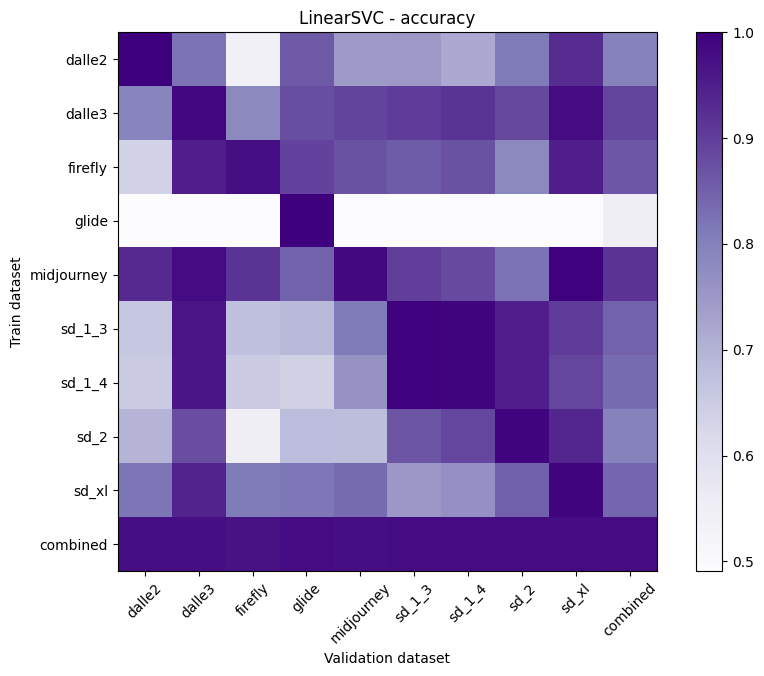

val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,1.000000,0.821875,0.540625,0.859375,0.743750,0.746875,0.715625,0.809375,0.928125,0.796181
dalle3,0.790625,0.987500,0.781250,0.875000,0.890625,0.903125,0.915625,0.884375,0.981250,0.889931
firefly,0.634375,0.950000,0.975000,0.893750,0.868750,0.856250,0.868750,0.781250,0.950000,0.864236
glide,0.490625,0.490625,0.490625,1.000000,0.490625,0.490625,0.490625,0.490625,0.490625,0.547222
midjourney,0.931250,0.981250,0.912500,0.846875,0.984375,0.900000,0.881250,0.821875,0.996875,0.917361
sd_1_3,0.659375,0.965625,0.671875,0.687500,0.809375,0.996875,0.990625,0.950000,0.903125,0.848264
sd_1_4,0.650000,0.962500,0.650000,0.637500,0.762500,0.996875,0.990625,0.950000,0.887500,0.831944
sd_2,0.696875,0.878125,0.550000,0.681250,0.678125,0.865625,0.887500,0.990625,0.937500,0.796181
sd_xl,0.818750,0.940625,0.809375,0.815625,0.834375,0.750000,0.765625,0.850000,0.990625,0.841667


val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,1.000000,0.821875,0.540625,0.859375,0.743750,0.746875,0.715625,0.809375,0.928125,0.796181
dalle3,0.790625,0.987500,0.781250,0.875000,0.890625,0.903125,0.915625,0.884375,0.981250,0.889931
firefly,0.634375,0.950000,0.975000,0.893750,0.868750,0.856250,0.868750,0.781250,0.950000,0.864236
glide,0.490625,0.490625,0.490625,1.000000,0.490625,0.490625,0.490625,0.490625,0.490625,0.547222
midjourney,0.931250,0.981250,0.912500,0.846875,0.984375,0.900000,0.881250,0.821875,0.996875,0.917361
sd_1_3,0.659375,0.965625,0.671875,0.687500,0.809375,0.996875,0.990625,0.950000,0.903125,0.848264
sd_1_4,0.650000,0.962500,0.650000,0.637500,0.762500,0.996875,0.990625,0.950000,0.887500,0.831944
sd_2,0.696875,0.878125,0.550000,0.681250,0.678125,0.865625,0.887500,0.990625,0.937500,0.796181
sd_xl,0.818750,0.940625,0.809375,0.815625,0.834375,0.750000,0.765625,0.850000,0.990625,0.841667


In [32]:
# Create a heatmap of results
df = pd.DataFrame(results).T
df.reset_index(inplace=True)
df.columns = ["train_dataset", "val_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

df_pivot = df.pivot(index=["train_dataset", "model"], columns="val_dataset", values="accuracy")
df_pivot = df_pivot.reindex(index=X_train.keys())

metric = "accuracy"
evaluation_data_name = "Validation"
df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric)

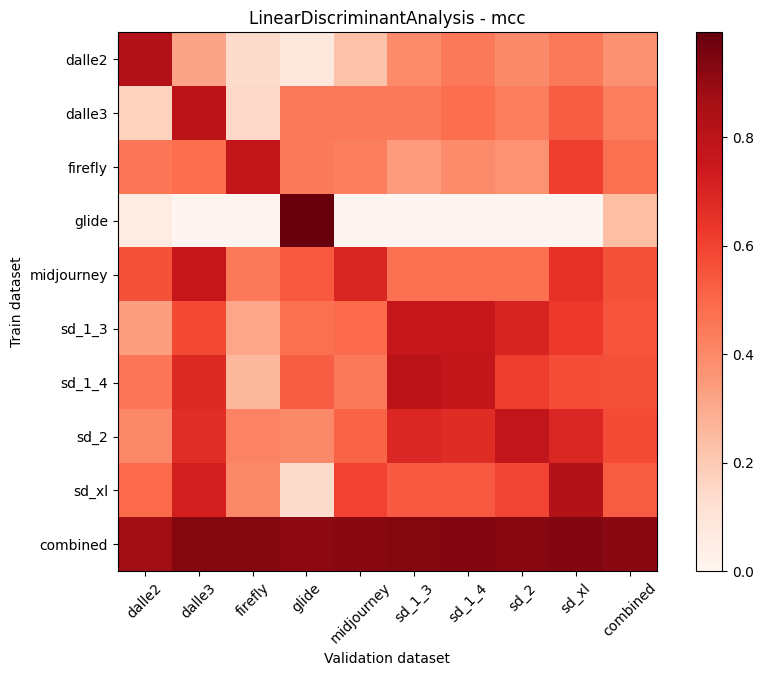

val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.819192,0.314882,0.136325,0.077097,0.228967,0.393389,0.447081,0.398824,0.452386,0.374524
dalle3,0.167182,0.795888,0.154417,0.448403,0.448403,0.442693,0.482794,0.436989,0.529181,0.432555
firefly,0.455899,0.483869,0.770198,0.444730,0.433563,0.343691,0.394429,0.371964,0.609480,0.476401
glide,0.054949,0.000000,0.000000,0.993768,0.000000,0.000000,0.000000,0.000000,0.000000,0.240384
midjourney,0.561035,0.764972,0.447007,0.537907,0.693657,0.475220,0.475220,0.475220,0.656365,0.562327
sd_1_3,0.332120,0.583665,0.309123,0.473828,0.496616,0.765826,0.765826,0.700177,0.625571,0.556241
sd_1_4,0.457664,0.681657,0.258750,0.530306,0.446543,0.796004,0.769646,0.610338,0.569991,0.564919
sd_2,0.401973,0.668685,0.418861,0.401973,0.509273,0.687371,0.674886,0.778417,0.687371,0.576586
sd_xl,0.490907,0.719496,0.400277,0.137974,0.601502,0.536861,0.542659,0.595537,0.821256,0.534932


val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.819192,0.314882,0.136325,0.077097,0.228967,0.393389,0.447081,0.398824,0.452386,0.363127
dalle3,0.167182,0.795888,0.154417,0.448403,0.448403,0.442693,0.482794,0.436989,0.529181,0.433994
firefly,0.455899,0.483869,0.770198,0.444730,0.433563,0.343691,0.394429,0.371964,0.609480,0.478647
glide,0.054949,0.000000,0.000000,0.993768,0.000000,0.000000,0.000000,0.000000,0.000000,0.116524
midjourney,0.561035,0.764972,0.447007,0.537907,0.693657,0.475220,0.475220,0.475220,0.656365,0.565178
sd_1_3,0.332120,0.583665,0.309123,0.473828,0.496616,0.765826,0.765826,0.700177,0.625571,0.561417
sd_1_4,0.457664,0.681657,0.258750,0.530306,0.446543,0.796004,0.769646,0.610338,0.569991,0.568989
sd_2,0.401973,0.668685,0.418861,0.401973,0.509273,0.687371,0.674886,0.778417,0.687371,0.580979
sd_xl,0.490907,0.719496,0.400277,0.137974,0.601502,0.536861,0.542659,0.595537,0.821256,0.538497


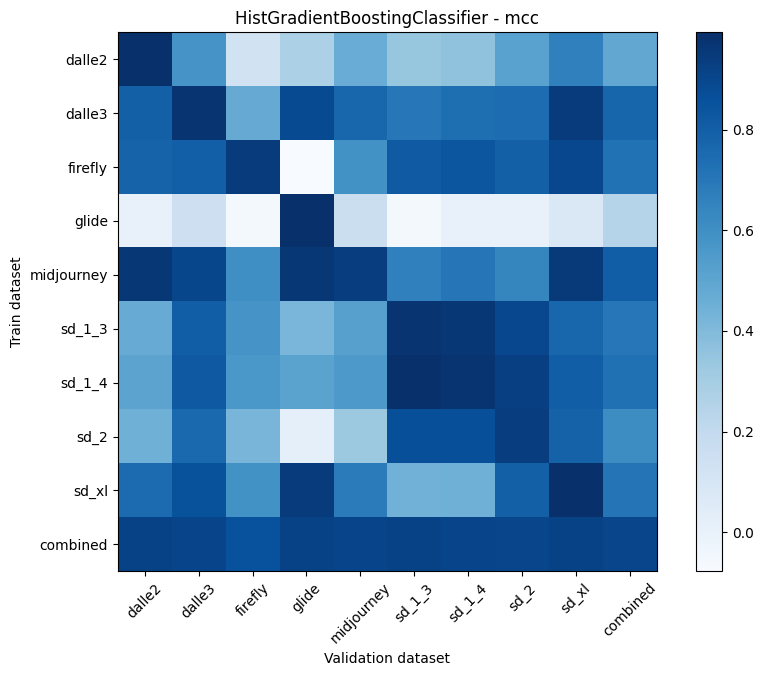

val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.993766,0.576090,0.129144,0.275433,0.465291,0.340942,0.357520,0.513836,0.662773,0.488606
dalle3,0.793174,0.968899,0.473955,0.883448,0.771571,0.698278,0.734517,0.745014,0.943755,0.773359
firefly,0.782331,0.798629,0.943755,-0.077969,0.587928,0.820677,0.837469,0.793174,0.895240,0.725242
glide,-0.001487,0.150860,-0.057049,0.993766,0.160815,-0.057049,-0.001487,-0.001487,0.073243,0.243514
midjourney,0.963139,0.900293,0.600920,0.963139,0.931236,0.662044,0.703631,0.641532,0.950256,0.804825
sd_1_3,0.469378,0.802309,0.576441,0.419107,0.523209,0.968762,0.962571,0.896833,0.770567,0.700633
sd_1_4,0.504199,0.825715,0.566530,0.509021,0.556970,0.993766,0.975073,0.926871,0.804360,0.729857
sd_2,0.448688,0.755581,0.423032,0.015715,0.325078,0.865990,0.865990,0.931414,0.787742,0.611588
sd_xl,0.747294,0.852932,0.590440,0.944680,0.682347,0.440556,0.445536,0.793812,0.987496,0.712595


val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.993766,0.576090,0.129144,0.275433,0.465291,0.340942,0.357520,0.513836,0.662773,0.479422
dalle3,0.793174,0.968899,0.473955,0.883448,0.771571,0.698278,0.734517,0.745014,0.943755,0.779179
firefly,0.782331,0.798629,0.943755,-0.077969,0.587928,0.820677,0.837469,0.793174,0.895240,0.709026
glide,-0.001487,0.150860,-0.057049,0.993766,0.160815,-0.057049,-0.001487,-0.001487,0.073243,0.140014
midjourney,0.963139,0.900293,0.600920,0.963139,0.931236,0.662044,0.703631,0.641532,0.950256,0.812910
sd_1_3,0.469378,0.802309,0.576441,0.419107,0.523209,0.968762,0.962571,0.896833,0.770567,0.709909
sd_1_4,0.504199,0.825715,0.566530,0.509021,0.556970,0.993766,0.975073,0.926871,0.804360,0.740278
sd_2,0.448688,0.755581,0.423032,0.015715,0.325078,0.865990,0.865990,0.931414,0.787742,0.602137
sd_xl,0.747294,0.852932,0.590440,0.944680,0.682347,0.440556,0.445536,0.793812,0.987496,0.720566


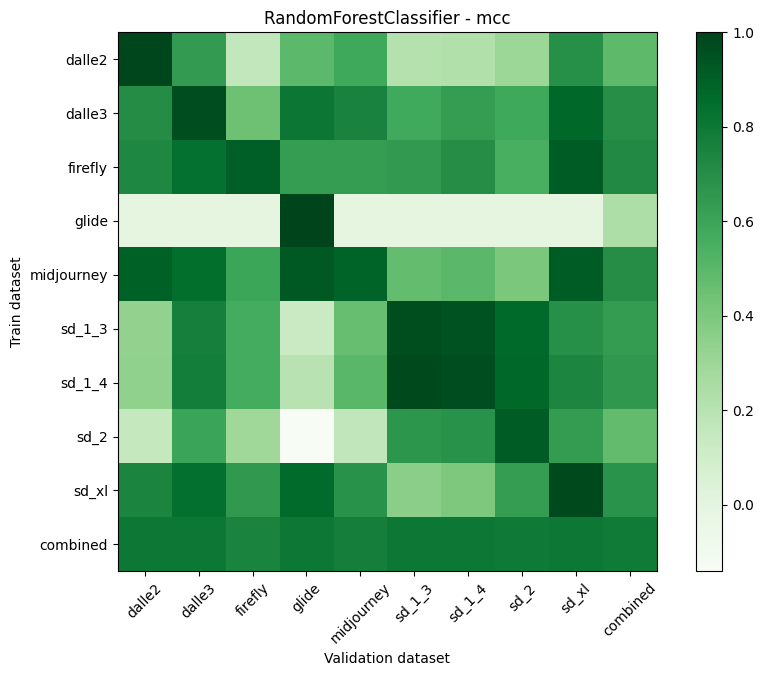

val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.987496,0.643343,0.160815,0.494531,0.580872,0.212470,0.220124,0.300297,0.692198,0.490762
dalle3,0.706137,0.962487,0.443828,0.805820,0.752551,0.572212,0.631074,0.581988,0.872767,0.697673
firefly,0.731648,0.833376,0.906224,0.630844,0.630844,0.646451,0.704606,0.553784,0.912520,0.723188
glide,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.240384
midjourney,0.893743,0.845196,0.594728,0.925228,0.887556,0.471859,0.497571,0.403710,0.912520,0.704606
sd_1_3,0.333140,0.765346,0.566771,0.127912,0.464424,0.968762,0.950303,0.862600,0.688961,0.637418
sd_1_4,0.338817,0.775808,0.566771,0.201753,0.503749,0.981260,0.962571,0.873895,0.739501,0.656491
sd_2,0.145945,0.600920,0.295217,-0.140849,0.162983,0.662044,0.682733,0.912561,0.636428,0.477747
sd_xl,0.742125,0.838831,0.650876,0.861345,0.680850,0.354237,0.397402,0.631074,0.981410,0.676385


val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.987496,0.643343,0.160815,0.494531,0.580872,0.212470,0.220124,0.300297,0.692198,0.476905
dalle3,0.706137,0.962487,0.443828,0.805820,0.752551,0.572212,0.631074,0.581988,0.872767,0.703207
firefly,0.731648,0.833376,0.906224,0.630844,0.630844,0.646451,0.704606,0.553784,0.912520,0.727811
glide,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111
midjourney,0.893743,0.845196,0.594728,0.925228,0.887556,0.471859,0.497571,0.403710,0.912520,0.714679
sd_1_3,0.333140,0.765346,0.566771,0.127912,0.464424,0.968762,0.950303,0.862600,0.688961,0.636469
sd_1_4,0.338817,0.775808,0.566771,0.201753,0.503749,0.981260,0.962571,0.873895,0.739501,0.660458
sd_2,0.145945,0.600920,0.295217,-0.140849,0.162983,0.662044,0.682733,0.912561,0.636428,0.439776
sd_xl,0.742125,0.838831,0.650876,0.861345,0.680850,0.354237,0.397402,0.631074,0.981410,0.682016


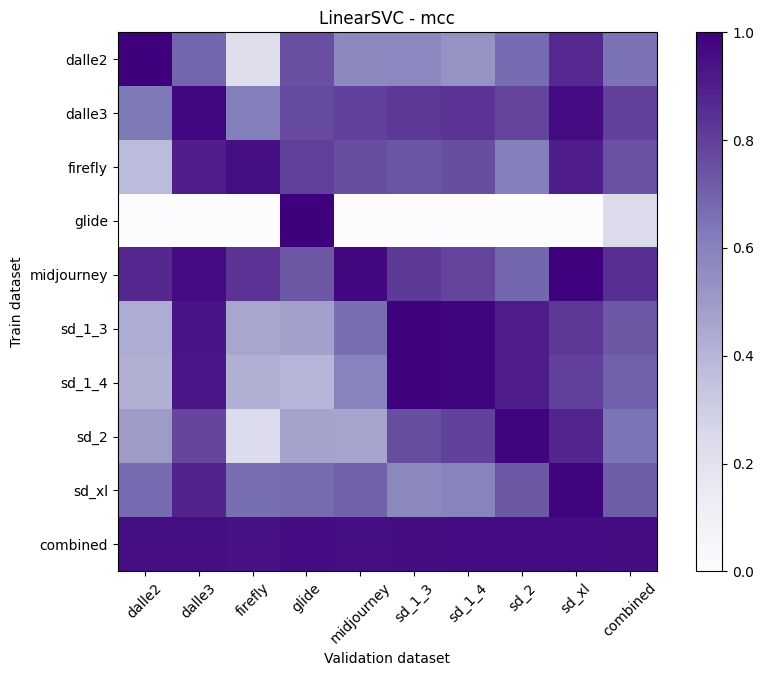

val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,1.000000,0.690720,0.225154,0.750104,0.571347,0.576069,0.528806,0.671317,0.865533,0.651002
dalle3,0.631074,0.975062,0.616296,0.768324,0.795002,0.816728,0.838831,0.784270,0.962487,0.793805
firefly,0.375431,0.901184,0.949982,0.798629,0.755581,0.734517,0.755581,0.612691,0.901184,0.747942
glide,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.240384
midjourney,0.869566,0.962805,0.836529,0.727062,0.968920,0.814993,0.783344,0.687267,0.993766,0.845006
sd_1_3,0.435558,0.932773,0.455445,0.479961,0.667652,0.993766,0.981265,0.903585,0.820343,0.729298
sd_1_4,0.420443,0.926871,0.420443,0.399961,0.595228,0.993766,0.981265,0.903585,0.793812,0.703197
sd_2,0.494531,0.778140,0.234850,0.470194,0.465291,0.757507,0.793812,0.981265,0.880791,0.647111
sd_xl,0.679008,0.885305,0.664157,0.674047,0.703981,0.571606,0.595799,0.729279,0.981260,0.715743


val_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,1.000000,0.690720,0.225154,0.750104,0.571347,0.576069,0.528806,0.671317,0.865533,0.653228
dalle3,0.631074,0.975062,0.616296,0.768324,0.795002,0.816728,0.838831,0.784270,0.962487,0.798675
firefly,0.375431,0.901184,0.949982,0.798629,0.755581,0.734517,0.755581,0.612691,0.901184,0.753865
glide,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111
midjourney,0.869566,0.962805,0.836529,0.727062,0.968920,0.814993,0.783344,0.687267,0.993766,0.849362
sd_1_3,0.435558,0.932773,0.455445,0.479961,0.667652,0.993766,0.981265,0.903585,0.820343,0.741150
sd_1_4,0.420443,0.926871,0.420443,0.399961,0.595228,0.993766,0.981265,0.903585,0.793812,0.715042
sd_2,0.494531,0.778140,0.234850,0.470194,0.465291,0.757507,0.793812,0.981265,0.880791,0.650709
sd_xl,0.679008,0.885305,0.664157,0.674047,0.703981,0.571606,0.595799,0.729279,0.981260,0.720493


In [33]:
# Create a heatmap of results
df = pd.DataFrame(results).T
df.reset_index(inplace=True)
df.columns = ["train_dataset", "val_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

metric = "mcc"
evaluation_data_name = "Validation"
df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric)

### Test data

In [34]:
results = {}
for dataset_name in models.keys():
    print(f"\n\n\n\n *** Evaluating models trained on {dataset_name}. ***")
    for test_dataset_name in X_test.keys():
        print(f"\n\nValidation set: {test_dataset_name}")
        for model_name, model in models[dataset_name].items():
            print() 
            # leave only the columns that are in the training set
            X_test_scaled = scalers[dataset_name].transform(X_test[test_dataset_name][X_train[dataset_name].columns])
            X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train[dataset_name].columns)
            accuracy, f1, precision, recall, mcc = evaluate_model(model, X_test_scaled, y_test[test_dataset_name], name=model_name)
            model_results = {
                "accuracy": accuracy,
                "f1": f1,
                "precision": precision,
                "recall": recall,
                "mcc": mcc
            }
            results[(dataset_name, test_dataset_name, model_name)] = model_results
            





 *** Evaluating models trained on dalle2. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9950
F1: 0.9950
Precision: 0.9950
Recall: 0.9950
MCC: 0.9900

Model: LinearDiscriminantAnalysis
Accuracy: 0.9225
F1: 0.9225
Precision: 0.9225
Recall: 0.9225
MCC: 0.8450

Model: RandomForestClassifier
Accuracy: 0.9875
F1: 0.9875
Precision: 0.9878
Recall: 0.9875
MCC: 0.9753

Model: LinearSVC
Accuracy: 0.9925
F1: 0.9925
Precision: 0.9926
Recall: 0.9925
MCC: 0.9851


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.7600
F1: 0.7466
Precision: 0.8298
Recall: 0.7600
MCC: 0.5856

Model: LinearDiscriminantAnalysis
Accuracy: 0.6375
F1: 0.6061
Precision: 0.7020
Recall: 0.6375
MCC: 0.3333

Model: RandomForestClassifier
Accuracy: 0.8000
F1: 0.7937
Precision: 0.8419
Recall: 0.8000
MCC: 0.6405

Model: LinearSVC
Accuracy: 0.8500
F1: 0.8472
Precision: 0.8775
Recall: 0.8500
MCC: 0.7270


Validation set: firefly

Model: HistGradientBoostingClassifier
Accur

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: dalle3

Model: HistGradientBoostingClassifier
Accuracy: 0.5175
F1: 0.3750
Precision: 0.6989
Recall: 0.5175
MCC: 0.1180

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: firefly

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3377
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9975
F1: 0.9975
Precision: 0.9975
Recall: 0.9975
MCC: 0.9950

Model: LinearDiscriminantAnalysis
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: RandomForestClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearSVC
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000


Validation set: midjourney

Model: HistGradientBoostingClassifier
Accuracy: 0.5300
F1: 0.4003
Precision: 0.7221
Recall: 0.5300
MCC: 0.1632

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_1_3

Model: HistGradientBoostingClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_1_4

Model: HistGradientBoostingClassifier
Accuracy: 0.5025
F1: 0.3432
Precision: 0.5840
Recall: 0.5025
MCC: 0.0290

Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_2

Model: HistGradientBoostingClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: sd_xl

Model: HistGradientBoostingClassifier
Accuracy: 0.5075
F1: 0.3540
Precision: 0.6519
Recall: 0.5075
MCC: 0.0675



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5611
F1: 0.4593
Precision: 0.7475
Recall: 0.5611
MCC: 0.2459

Model: LinearDiscriminantAnalysis
Accuracy: 0.5556
F1: 0.4462
Precision: 0.7647
Recall: 0.5556
MCC: 0.2425

Model: RandomForestClassifier
Accuracy: 0.5556
F1: 0.4462
Precision: 0.7647
Recall: 0.5556
MCC: 0.2425

Model: LinearSVC
Accuracy: 0.5556
F1: 0.4462
Precision: 0.7647
Recall: 0.5556
MCC: 0.2425




 *** Evaluating models trained on midjourney. ***


Validation set: dalle2

Model: HistGradientBoostingClassifier
Accuracy: 0.9750
F1: 0.9750
Precision: 0.9752
Recall: 0.9750
MCC: 0.9502

Model: LinearDiscriminantAnalysis
Accuracy: 0.7350
F1: 0.7345
Pr

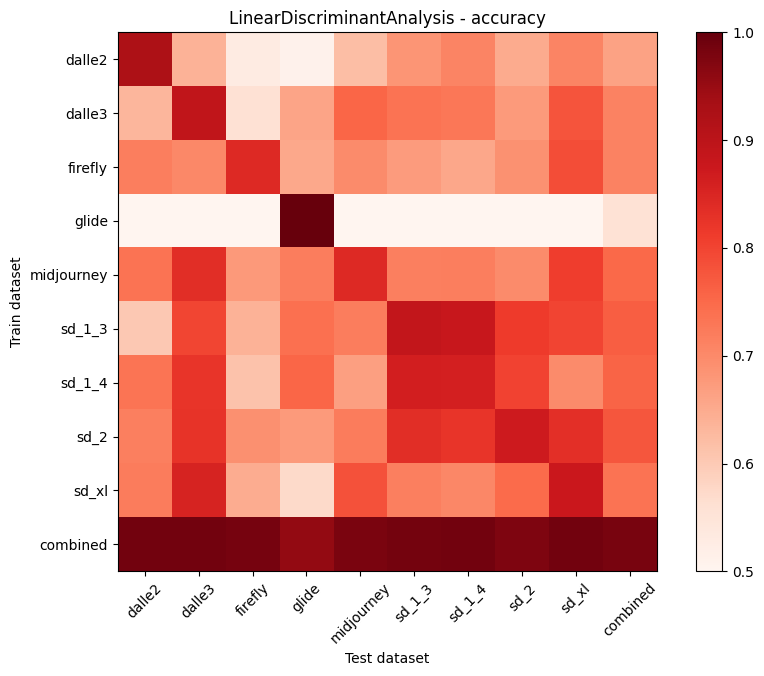

test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.9225,0.6375,0.5275,0.5100,0.6200,0.6825,0.7075,0.6500,0.7075,0.662778
dalle3,0.6325,0.8925,0.5575,0.6600,0.7550,0.7350,0.7300,0.6750,0.7775,0.712778
firefly,0.7175,0.7025,0.8425,0.6525,0.6975,0.6725,0.6550,0.6875,0.7875,0.712778
glide,0.5000,0.5000,0.5000,1.0000,0.5000,0.5000,0.5000,0.5000,0.5000,0.555556
midjourney,0.7350,0.8350,0.6775,0.7200,0.8425,0.7150,0.7175,0.6975,0.8100,0.750000
sd_1_3,0.6025,0.7975,0.6375,0.7400,0.7200,0.8875,0.8800,0.8125,0.8000,0.764167
sd_1_4,0.7325,0.8225,0.6125,0.7550,0.6675,0.8625,0.8600,0.8025,0.6975,0.756944
sd_2,0.7150,0.8250,0.6900,0.6750,0.7225,0.8350,0.8225,0.8700,0.8325,0.776389
sd_xl,0.7225,0.8550,0.6475,0.5725,0.7825,0.7150,0.7050,0.7475,0.8750,0.735833


test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.9225,0.6375,0.5275,0.5100,0.6200,0.6825,0.7075,0.6500,0.7075,0.662778
dalle3,0.6325,0.8925,0.5575,0.6600,0.7550,0.7350,0.7300,0.6750,0.7775,0.712778
firefly,0.7175,0.7025,0.8425,0.6525,0.6975,0.6725,0.6550,0.6875,0.7875,0.712778
glide,0.5000,0.5000,0.5000,1.0000,0.5000,0.5000,0.5000,0.5000,0.5000,0.555556
midjourney,0.7350,0.8350,0.6775,0.7200,0.8425,0.7150,0.7175,0.6975,0.8100,0.750000
sd_1_3,0.6025,0.7975,0.6375,0.7400,0.7200,0.8875,0.8800,0.8125,0.8000,0.764167
sd_1_4,0.7325,0.8225,0.6125,0.7550,0.6675,0.8625,0.8600,0.8025,0.6975,0.756944
sd_2,0.7150,0.8250,0.6900,0.6750,0.7225,0.8350,0.8225,0.8700,0.8325,0.776389
sd_xl,0.7225,0.8550,0.6475,0.5725,0.7825,0.7150,0.7050,0.7475,0.8750,0.735833


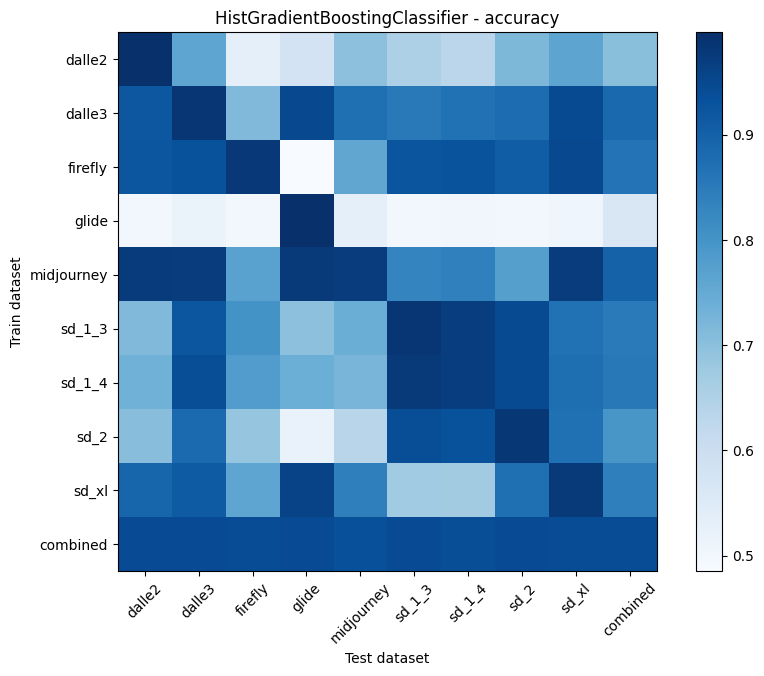

test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.9950,0.7600,0.5300,0.5775,0.6975,0.6525,0.6300,0.7175,0.7625,0.702500
dalle3,0.9200,0.9850,0.7150,0.9475,0.8725,0.8525,0.8675,0.8775,0.9450,0.886944
firefly,0.9225,0.9300,0.9800,0.4850,0.7575,0.9250,0.9275,0.9075,0.9475,0.864722
glide,0.5000,0.5175,0.5000,0.9975,0.5300,0.4975,0.5025,0.4975,0.5075,0.561111
midjourney,0.9750,0.9725,0.7675,0.9775,0.9725,0.8300,0.8375,0.7750,0.9725,0.897778
sd_1_3,0.7150,0.9225,0.8025,0.6975,0.7425,0.9850,0.9675,0.9450,0.8675,0.849444
sd_1_4,0.7350,0.9375,0.7800,0.7400,0.7250,0.9775,0.9675,0.9450,0.8750,0.853611
sd_2,0.7050,0.8825,0.6875,0.5200,0.6350,0.9375,0.9300,0.9825,0.8700,0.794444
sd_xl,0.8925,0.9125,0.7600,0.9575,0.8400,0.6725,0.6700,0.8725,0.9775,0.839444


test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.9950,0.7600,0.5300,0.5775,0.6975,0.6525,0.6300,0.7175,0.7625,0.702500
dalle3,0.9200,0.9850,0.7150,0.9475,0.8725,0.8525,0.8675,0.8775,0.9450,0.886944
firefly,0.9225,0.9300,0.9800,0.4850,0.7575,0.9250,0.9275,0.9075,0.9475,0.864722
glide,0.5000,0.5175,0.5000,0.9975,0.5300,0.4975,0.5025,0.4975,0.5075,0.561111
midjourney,0.9750,0.9725,0.7675,0.9775,0.9725,0.8300,0.8375,0.7750,0.9725,0.897778
sd_1_3,0.7150,0.9225,0.8025,0.6975,0.7425,0.9850,0.9675,0.9450,0.8675,0.849444
sd_1_4,0.7350,0.9375,0.7800,0.7400,0.7250,0.9775,0.9675,0.9450,0.8750,0.853611
sd_2,0.7050,0.8825,0.6875,0.5200,0.6350,0.9375,0.9300,0.9825,0.8700,0.794444
sd_xl,0.8925,0.9125,0.7600,0.9575,0.8400,0.6725,0.6700,0.8725,0.9775,0.839444


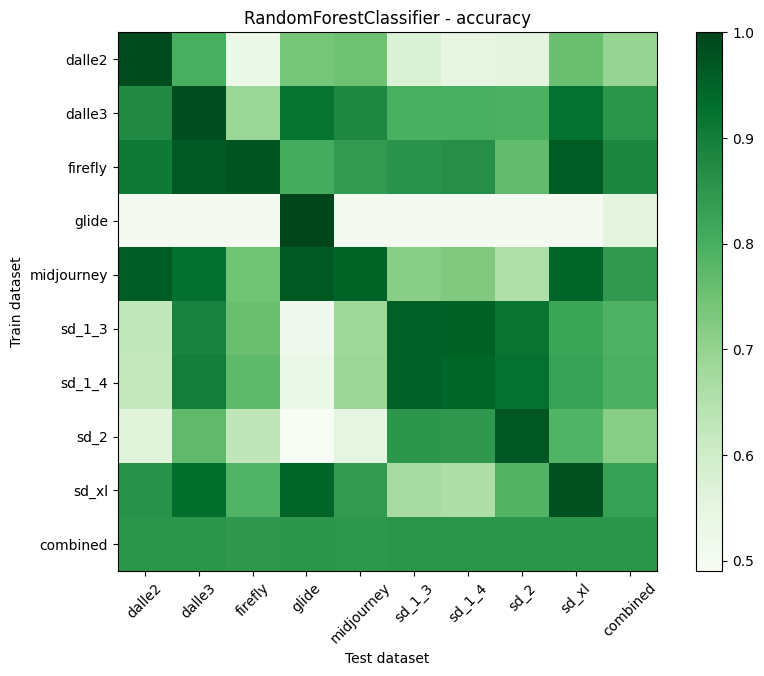

test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.9875,0.8000,0.5300,0.7400,0.7525,0.5750,0.5475,0.5550,0.7550,0.693611
dalle3,0.8750,0.9825,0.6900,0.9200,0.8775,0.7975,0.7975,0.7950,0.9250,0.851111
firefly,0.9075,0.9650,0.9725,0.8050,0.8400,0.8550,0.8650,0.7650,0.9625,0.881944
glide,0.5000,0.5000,0.5000,1.0000,0.5000,0.5000,0.5000,0.5000,0.5000,0.555556
midjourney,0.9625,0.9275,0.7500,0.9675,0.9500,0.7150,0.7275,0.6550,0.9450,0.844444
sd_1_3,0.6250,0.8900,0.7575,0.5125,0.6850,0.9575,0.9525,0.9175,0.8200,0.790833
sd_1_4,0.6225,0.9000,0.7725,0.5325,0.6875,0.9575,0.9475,0.9250,0.8250,0.796667
sd_2,0.5600,0.7675,0.6300,0.4900,0.5500,0.8500,0.8450,0.9700,0.7875,0.716667
sd_xl,0.8575,0.9325,0.7875,0.9475,0.8400,0.6700,0.6575,0.7850,0.9800,0.828611


test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.9875,0.8000,0.5300,0.7400,0.7525,0.5750,0.5475,0.5550,0.7550,0.693611
dalle3,0.8750,0.9825,0.6900,0.9200,0.8775,0.7975,0.7975,0.7950,0.9250,0.851111
firefly,0.9075,0.9650,0.9725,0.8050,0.8400,0.8550,0.8650,0.7650,0.9625,0.881944
glide,0.5000,0.5000,0.5000,1.0000,0.5000,0.5000,0.5000,0.5000,0.5000,0.555556
midjourney,0.9625,0.9275,0.7500,0.9675,0.9500,0.7150,0.7275,0.6550,0.9450,0.844444
sd_1_3,0.6250,0.8900,0.7575,0.5125,0.6850,0.9575,0.9525,0.9175,0.8200,0.790833
sd_1_4,0.6225,0.9000,0.7725,0.5325,0.6875,0.9575,0.9475,0.9250,0.8250,0.796667
sd_2,0.5600,0.7675,0.6300,0.4900,0.5500,0.8500,0.8450,0.9700,0.7875,0.716667
sd_xl,0.8575,0.9325,0.7875,0.9475,0.8400,0.6700,0.6575,0.7850,0.9800,0.828611


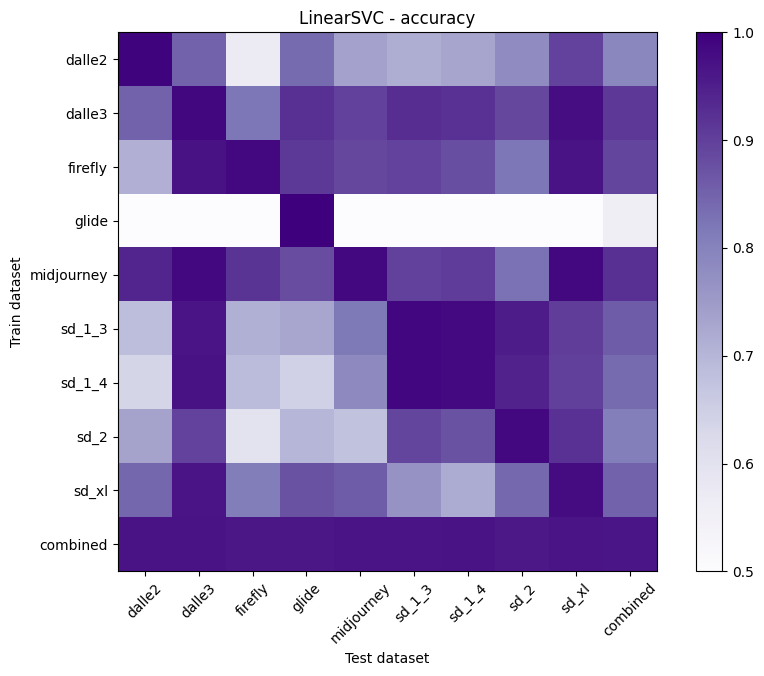

test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.9925,0.8500,0.5700,0.8375,0.7375,0.7150,0.7300,0.7775,0.8950,0.789444
dalle3,0.8500,0.9900,0.8200,0.9225,0.8975,0.9275,0.9200,0.8875,0.9775,0.910278
firefly,0.7100,0.9725,0.9850,0.9100,0.8875,0.8950,0.8775,0.8200,0.9675,0.891667
glide,0.5000,0.5000,0.5000,1.0000,0.5000,0.5000,0.5000,0.5000,0.5000,0.555556
midjourney,0.9400,0.9850,0.9175,0.8825,0.9850,0.8975,0.9050,0.8275,0.9850,0.925000
sd_1_3,0.6850,0.9650,0.7125,0.7275,0.8150,0.9875,0.9825,0.9550,0.9025,0.859167
sd_1_4,0.6350,0.9700,0.6875,0.6450,0.7825,0.9875,0.9825,0.9450,0.9000,0.837222
sd_2,0.7350,0.8950,0.5975,0.7000,0.6775,0.8925,0.8725,0.9850,0.9200,0.808333
sd_xl,0.8425,0.9650,0.8100,0.8725,0.8575,0.7650,0.7200,0.8400,0.9800,0.850278


test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.9925,0.8500,0.5700,0.8375,0.7375,0.7150,0.7300,0.7775,0.8950,0.789444
dalle3,0.8500,0.9900,0.8200,0.9225,0.8975,0.9275,0.9200,0.8875,0.9775,0.910278
firefly,0.7100,0.9725,0.9850,0.9100,0.8875,0.8950,0.8775,0.8200,0.9675,0.891667
glide,0.5000,0.5000,0.5000,1.0000,0.5000,0.5000,0.5000,0.5000,0.5000,0.555556
midjourney,0.9400,0.9850,0.9175,0.8825,0.9850,0.8975,0.9050,0.8275,0.9850,0.925000
sd_1_3,0.6850,0.9650,0.7125,0.7275,0.8150,0.9875,0.9825,0.9550,0.9025,0.859167
sd_1_4,0.6350,0.9700,0.6875,0.6450,0.7825,0.9875,0.9825,0.9450,0.9000,0.837222
sd_2,0.7350,0.8950,0.5975,0.7000,0.6775,0.8925,0.8725,0.9850,0.9200,0.808333
sd_xl,0.8425,0.9650,0.8100,0.8725,0.8575,0.7650,0.7200,0.8400,0.9800,0.850278


In [35]:
# Create a heatmap of results
df = pd.DataFrame(results).T
df.reset_index(inplace=True)
df.columns = ["train_dataset", "test_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

metric = "accuracy"
evaluation_data_name = "Test"
df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric)

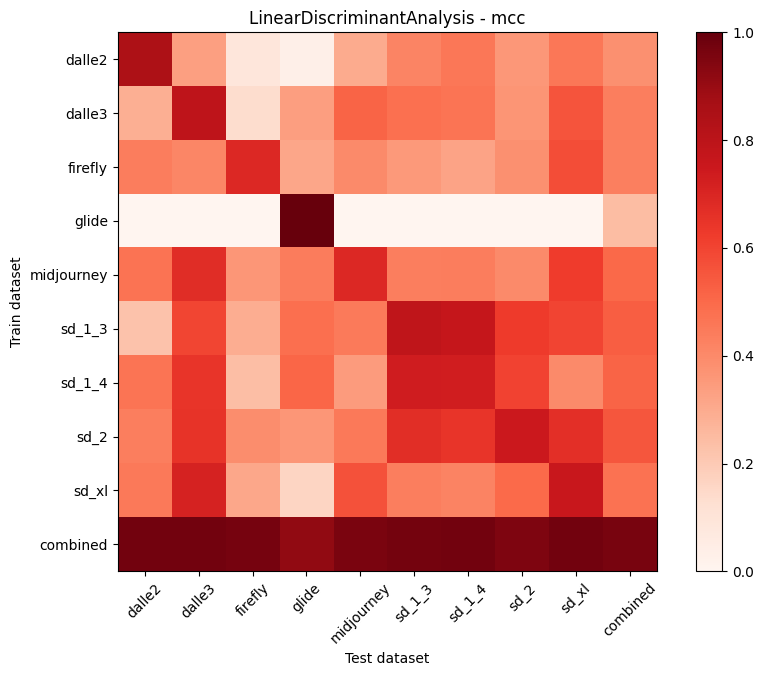

test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.845011,0.333297,0.088782,0.034943,0.300000,0.414779,0.458466,0.356436,0.458466,0.379646
dalle3,0.287133,0.792253,0.136119,0.338990,0.515073,0.477804,0.468535,0.366900,0.557522,0.436697
firefly,0.439019,0.410628,0.689575,0.316309,0.401191,0.354079,0.321041,0.382340,0.575007,0.430066
glide,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.242536
midjourney,0.471915,0.674091,0.362703,0.443203,0.690415,0.433680,0.438439,0.400489,0.621119,0.500902
sd_1_3,0.224211,0.595067,0.291864,0.484108,0.446499,0.785770,0.768697,0.625070,0.600030,0.530104
sd_1_4,0.468106,0.646367,0.240676,0.511254,0.345531,0.732744,0.727161,0.605189,0.401938,0.515016
sd_2,0.437140,0.650521,0.390468,0.362466,0.451184,0.671209,0.645395,0.746333,0.666008,0.553685
sd_xl,0.451184,0.713577,0.310824,0.163784,0.565573,0.437140,0.418454,0.498306,0.757460,0.476245


test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.845011,0.333297,0.088782,0.034943,0.300000,0.414779,0.458466,0.356436,0.458466,0.365575
dalle3,0.287133,0.792253,0.136119,0.338990,0.515073,0.477804,0.468535,0.366900,0.557522,0.437814
firefly,0.439019,0.410628,0.689575,0.316309,0.401191,0.354079,0.321041,0.382340,0.575007,0.432132
glide,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111
midjourney,0.471915,0.674091,0.362703,0.443203,0.690415,0.433680,0.438439,0.400489,0.621119,0.504006
sd_1_3,0.224211,0.595067,0.291864,0.484108,0.446499,0.785770,0.768697,0.625070,0.600030,0.535702
sd_1_4,0.468106,0.646367,0.240676,0.511254,0.345531,0.732744,0.727161,0.605189,0.401938,0.519885
sd_2,0.437140,0.650521,0.390468,0.362466,0.451184,0.671209,0.645395,0.746333,0.666008,0.557858
sd_xl,0.451184,0.713577,0.310824,0.163784,0.565573,0.437140,0.418454,0.498306,0.757460,0.479589


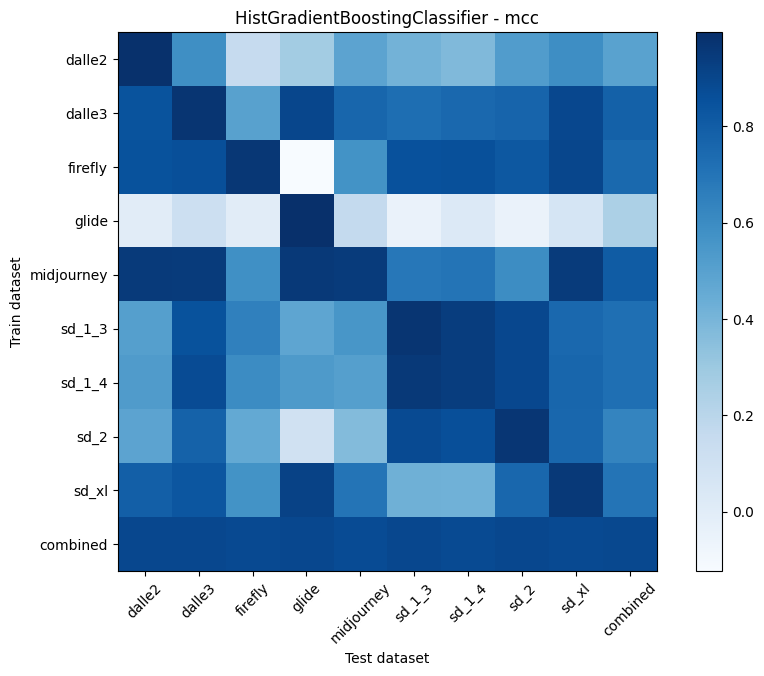

test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.990050,0.585639,0.153093,0.274272,0.487033,0.413381,0.374654,0.518823,0.589562,0.495017
dalle3,0.844232,0.970437,0.499899,0.895908,0.759582,0.725312,0.750949,0.768261,0.891115,0.784792
firefly,0.848839,0.862765,0.960192,-0.123404,0.568939,0.853464,0.858106,0.821443,0.895908,0.746172
glide,0.000000,0.118002,0.000000,0.995012,0.163239,-0.050063,0.028976,-0.050063,0.067505,0.245943
midjourney,0.950190,0.945106,0.582357,0.955299,0.945106,0.685458,0.698078,0.594603,0.945106,0.802844
sd_1_3,0.507077,0.850644,0.647151,0.478735,0.551145,0.970049,0.935292,0.892189,0.754342,0.724006
sd_1_4,0.526299,0.875887,0.600245,0.534522,0.509819,0.955585,0.935105,0.890401,0.761078,0.723797
sd_2,0.487130,0.778437,0.458349,0.096477,0.368243,0.877471,0.863504,0.965109,0.756877,0.631501
sd_xl,0.793385,0.829586,0.570122,0.915103,0.702301,0.425383,0.421103,0.758086,0.955299,0.701362


test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.990050,0.585639,0.153093,0.274272,0.487033,0.413381,0.374654,0.518823,0.589562,0.487390
dalle3,0.844232,0.970437,0.499899,0.895908,0.759582,0.725312,0.750949,0.768261,0.891115,0.789521
firefly,0.848839,0.862765,0.960192,-0.123404,0.568939,0.853464,0.858106,0.821443,0.895908,0.727361
glide,0.000000,0.118002,0.000000,0.995012,0.163239,-0.050063,0.028976,-0.050063,0.067505,0.141401
midjourney,0.950190,0.945106,0.582357,0.955299,0.945106,0.685458,0.698078,0.594603,0.945106,0.811256
sd_1_3,0.507077,0.850644,0.647151,0.478735,0.551145,0.970049,0.935292,0.892189,0.754342,0.731847
sd_1_4,0.526299,0.875887,0.600245,0.534522,0.509819,0.955585,0.935105,0.890401,0.761078,0.732105
sd_2,0.487130,0.778437,0.458349,0.096477,0.368243,0.877471,0.863504,0.965109,0.756877,0.627955
sd_xl,0.793385,0.829586,0.570122,0.915103,0.702301,0.425383,0.421103,0.758086,0.955299,0.707819


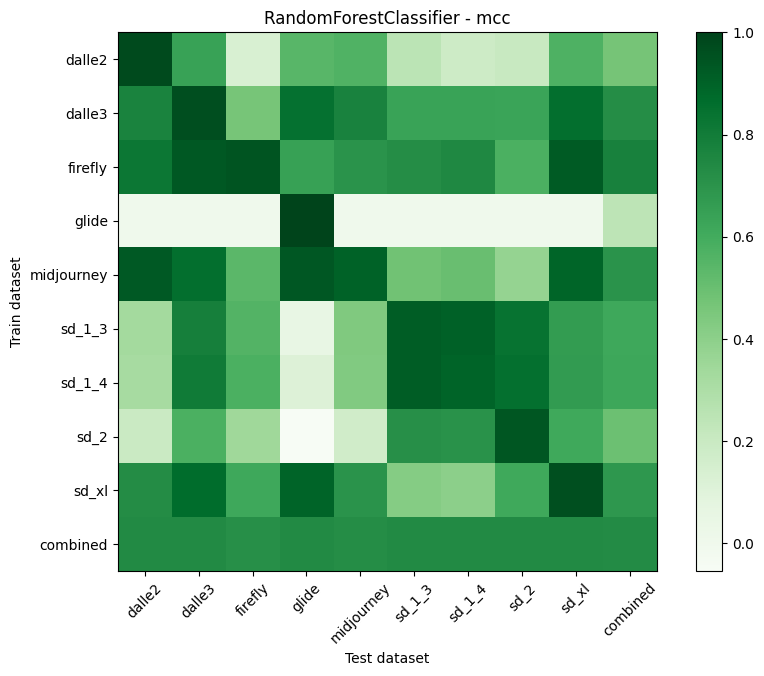

test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.975305,0.640513,0.131590,0.543807,0.563912,0.250000,0.183176,0.202733,0.567930,0.468447
dalle3,0.765466,0.965109,0.462487,0.845129,0.769777,0.636455,0.636455,0.632401,0.854282,0.724825
firefly,0.820443,0.930000,0.945106,0.643856,0.702301,0.727832,0.745053,0.578277,0.925012,0.774651
glide,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.242536
midjourney,0.926402,0.855096,0.538195,0.936981,0.900405,0.478843,0.500098,0.374174,0.890178,0.700473
sd_1_3,0.328976,0.785677,0.558014,0.051640,0.436322,0.915103,0.905011,0.836770,0.662794,0.613586
sd_1_4,0.317147,0.802572,0.578422,0.112173,0.434471,0.915561,0.895101,0.850383,0.667906,0.619326
sd_2,0.195724,0.577115,0.342135,-0.054413,0.170523,0.715965,0.707330,0.940423,0.610262,0.492937
sd_xl,0.732121,0.866833,0.615061,0.895549,0.702301,0.421103,0.399479,0.610964,0.960432,0.683128


test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.975305,0.640513,0.131590,0.543807,0.563912,0.250000,0.183176,0.202733,0.567930,0.450996
dalle3,0.765466,0.965109,0.462487,0.845129,0.769777,0.636455,0.636455,0.632401,0.854282,0.729729
firefly,0.820443,0.930000,0.945106,0.643856,0.702301,0.727832,0.745053,0.578277,0.925012,0.779764
glide,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111
midjourney,0.926402,0.855096,0.538195,0.936981,0.900405,0.478843,0.500098,0.374174,0.890178,0.711153
sd_1_3,0.328976,0.785677,0.558014,0.051640,0.436322,0.915103,0.905011,0.836770,0.662794,0.608923
sd_1_4,0.317147,0.802572,0.578422,0.112173,0.434471,0.915561,0.895101,0.850383,0.667906,0.619304
sd_2,0.195724,0.577115,0.342135,-0.054413,0.170523,0.715965,0.707330,0.940423,0.610262,0.467229
sd_xl,0.732121,0.866833,0.615061,0.895549,0.702301,0.421103,0.399479,0.610964,0.960432,0.689316


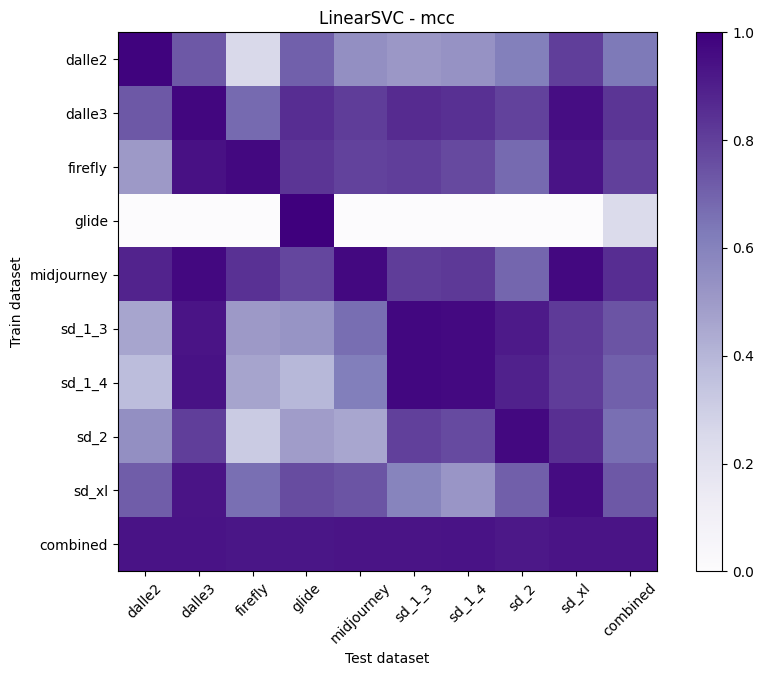

test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,combined
train_dataset,,,,,,,,,,
dalle2,0.985111,0.727001,0.251002,0.706438,0.546673,0.510892,0.534775,0.610010,0.803118,0.628992
dalle3,0.727001,0.980049,0.677980,0.851680,0.807460,0.860710,0.847189,0.790169,0.955107,0.829875
firefly,0.502895,0.945295,0.970000,0.829384,0.790169,0.803118,0.773079,0.677980,0.935573,0.797348
glide,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.242536
midjourney,0.882830,0.970049,0.841601,0.779973,0.970049,0.806048,0.819269,0.687771,0.970049,0.855190
sd_1_3,0.458259,0.930419,0.503047,0.527158,0.667386,0.975110,0.965012,0.911140,0.814848,0.740276
sd_1_4,0.373026,0.940188,0.462373,0.390645,0.615012,0.975110,0.965012,0.892189,0.810441,0.703747
sd_2,0.546401,0.804658,0.314772,0.491029,0.454764,0.800364,0.766465,0.970049,0.848355,0.661902
sd_xl,0.714638,0.930745,0.661863,0.764605,0.739445,0.590202,0.518869,0.710534,0.960048,0.727460


test_dataset,dalle2,dalle3,firefly,glide,midjourney,sd_1_3,sd_1_4,sd_2,sd_xl,average
train_dataset,,,,,,,,,,
dalle2,0.985111,0.727001,0.251002,0.706438,0.546673,0.510892,0.534775,0.610010,0.803118,0.630558
dalle3,0.727001,0.980049,0.677980,0.851680,0.807460,0.860710,0.847189,0.790169,0.955107,0.833038
firefly,0.502895,0.945295,0.970000,0.829384,0.790169,0.803118,0.773079,0.677980,0.935573,0.803055
glide,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111
midjourney,0.882830,0.970049,0.841601,0.779973,0.970049,0.806048,0.819269,0.687771,0.970049,0.858626
sd_1_3,0.458259,0.930419,0.503047,0.527158,0.667386,0.975110,0.965012,0.911140,0.814848,0.750264
sd_1_4,0.373026,0.940188,0.462373,0.390645,0.615012,0.975110,0.965012,0.892189,0.810441,0.713777
sd_2,0.546401,0.804658,0.314772,0.491029,0.454764,0.800364,0.766465,0.970049,0.848355,0.666317
sd_xl,0.714638,0.930745,0.661863,0.764605,0.739445,0.590202,0.518869,0.710534,0.960048,0.732328


In [36]:
# Create a heatmap of results
df = pd.DataFrame(results).T
df.reset_index(inplace=True)
df.columns = ["train_dataset", "test_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

metric = "mcc"
evaluation_data_name = "Test"
df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name=evaluation_data_name, metric=metric)
df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name=evaluation_data_name, metric=metric)

## Safe models and scalers

In [37]:
# for each dataset save models and scalers
import joblib

for dataset_name in models.keys():
    for model_name, model in models[dataset_name].items():
        models_dir_path = f"models/synthbuster/standard/{dataset_name}"
        scalers_dir_path = f"scalers/synthbuster/standard/{dataset_name}"
        os.makedirs(models_dir_path, exist_ok=True)
        os.makedirs(scalers_dir_path, exist_ok=True)
        joblib.dump(model, os.path.join(models_dir_path, f"{dataset_name}_{model_name}.joblib"))
        joblib.dump(scalers[dataset_name], os.path.join(scalers_dir_path, f"{dataset_name}_{model_name}.joblib"))